In [ ]:
!mkdir data

In [ ]:
!cp "/content/drive/MyDrive/Dacon/data/train.csv" "/content/data/train.csv"
!cp "/content/drive/MyDrive/Dacon/data/test.csv" "/content/data/test.csv"
!cp "/content/drive/MyDrive/Dacon/data/sample_submission.csv" "/content/data/sample_submission.csv"

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization


  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=1a41924387b06881117abc054ade7e7615cefdf47b8e2f975202339eba79ce4f
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
train = pd.read_csv('/content/data/train.csv')
test = pd.read_csv('/content/data/test.csv')
submission = pd.read_csv('/content/data/sample_submission.csv')

### 1. 데이터 로드

In [ ]:
train.shape

(26457, 20)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
# 타겟값의 분포 확인
train['credit'].value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

### 2. 타겟값에 따라 continuous 피처의 분포도, categorical 피처의 분포도 확인 
-> 주요 피처 확인

In [ ]:
# numeric 피처 중에 categorical/continuous 피처 분리
num_columns = train.dtypes[train.dtypes != 'object'].index.tolist()
unique_len_num = train[num_columns].apply(lambda x : len(x.unique()))
print(unique_len_num)
# unique_len_num 보면서 분리 
continuous = ['index','income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED','begin_month', 'child_num', 'family_size']
ordinal = ['family_size', 'child_num'] # 혹시나 해서 ordinal 피처를 다시 분리 해놓기 
categorical = [column for column in num_columns if column not in continuous]
print('categorical feature', categorical)
del continuous[0]
print('continous feature', continuous)

index            26457
child_num            9
income_total       249
DAYS_BIRTH        6621
DAYS_EMPLOYED     3470
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
family_size         10
begin_month         61
credit               3
dtype: int64
categorical feature ['FLAG_MOBIL', 'work_phone', 'phone', 'email', 'credit']
continous feature ['income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'child_num', 'family_size']


In [ ]:
def show_hist_by_target(df, columns):
    cond_2 = (df['credit'] == 2)
    cond_1 = (df['credit'] == 1)
    cond_0 = (df['credit'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='credit', y=column, data=df, ax=axs[0][0] )
        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='blue')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='red')
        sns.distplot(df[cond_2][column], ax=axs[0][1], label='2', color='green')

show_hist_by_target(train, continuous)

In [ ]:
# object피처를 categorical 피처에 합치기
object_columns = train.dtypes[train.dtypes == 'object'].index.tolist()
categorical = object_columns + categorical
del categorical[-1] # 'credit' 제거 
print('categorical feature', categorical)

categorical feature ['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type', 'FLAG_MOBIL', 'work_phone', 'phone', 'email']


In [ ]:
# credit에 따라 categorical 피처들 분포 확인 
def show_category_by_target(df, columns):
    for column in columns:
        chart = sns.catplot(x=column, col="credit", data=df, kind="count")
        chart.set_xticklabels(rotation=65)
        
show_category_by_target(train, categorical)

In [ ]:
corr = train[continuous].corr()
sns.heatmap(corr, annot=True, cmap='Blues')

In [ ]:
#연속형 변수 분포 확인 
sns.distplot(train['income_total']) # skew(오른쪽으로 긴 꼬리)
sns.distplot(train['DAYS_BIRTH']) # 정규분포 형태 
sns.distplot(train['DAYS_EMPLOYED']) # 양끝으로 두 분포 형태(이상치 의심)

### 3. train과 test 데이터 합쳐서 피처엔지니어링 

In [ ]:
data = pd.concat([train, test], axis=0)

#### 3-0. 데이콘 강의_전처리 부분 정리

In [ ]:
len(data['gender'].unique())

2

In [ ]:
# 데이터의 모든 컬럼의 고유값의 개수를 확인  
unique_len = data.apply(lambda x : len(x.unique()))

In [ ]:
unique_len

index            36457
gender               2
car                  2
reality              2
child_num            9
income_total       265
income_type          5
edu_type             5
family_type          5
house_type           6
DAYS_BIRTH        7183
DAYS_EMPLOYED     3640
FLAG_MOBIL           1
work_phone           2
phone                2
email                2
occyp_type          19
family_size         10
begin_month         61
credit               4
dtype: int64

In [ ]:
# 고유값 개수 2개 이하/ 2개 초과 10개 이하/ 10개 초과 그룹 3개로 나누기 
group1 = unique_len[unique_len <= 2].index # binary 
group2 = unique_len[(unique_len > 2) & (unique_len <=10)].index # multi 
group3 = unique_len[unique_len > 10].index # contiunous 

In [ ]:
# <group1> 전처리 
data[group1] # 확인 결과, gender, car, reality 문자열값을 0,1로 바꿔주기 
data['gender'] = data['gender'].replace(['F', 'M'], [0,1])
data['car'] = data['car'].replace(['N','Y'], [0,1])
data['reality'] = data['reality'].replace(['N','Y'],[0,1])
data[group1]

,gender,car,reality,FLAG_MOBIL,work_phone,phone,email
0,0,0,0,1,0,0,0
1,0,0,1,1,0,0,1
2,1,1,1,1,0,1,0
3,0,0,1,1,0,1,0
4,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...
9995,0,1,1,1,1,1,0
9996,1,1,1,1,1,0,0
9997,0,0,1,1,0,0,0
9998,0,1,0,1,0,1,0


In [ ]:
# <group2> 전처리
data[group2] 
# child_num 는 따로 처리, 레이블인코딩-income_type, family_type, house_type, 매핑처리(ordinary)-edu_type

,child_num,income_type,edu_type,family_type,house_type,family_size,credit
0,0,Commercial associate,Higher education,Married,Municipal apartment,2.0,1.0
1,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,3.0,1.0
2,0,Working,Higher education,Married,House / apartment,2.0,2.0
3,0,Commercial associate,Secondary / secondary special,Married,House / apartment,2.0,0.0
4,0,State servant,Higher education,Married,House / apartment,2.0,2.0
...,...,...,...,...,...,...,...
9995,0,Working,Incomplete higher,Married,House / apartment,2.0,NaN
9996,0,Working,Secondary / secondary special,Civil marriage,House / apartment,2.0,NaN
9997,0,Working,Secondary / secondary special,Married,House / apartment,2.0,NaN
9998,0,Commercial associate,Secondary / secondary special,Married,House / apartment,2.0,NaN


In [ ]:
# data['child_num'].value_counts().plot.bar()  #child_num의 분포를 보기 (value_counts()와 plot.bar() 이용 )
# 3부터 19까지의 값은 거의 존재하지 않는 값이므로 이상치로 취급하고 2 초과인 값을 모두 2로 변경해주기 
# sns.box_plot(data['child_num']) # child_num > 2.5 면 이상치로 나옴 
data.loc[data['child_num'] > 2, 'child_num'] = 2
# data['child_num'].value_counts().plot.bar() # 다시 분포 확인 

In [ ]:
# sklearn.preprocessing의 LableEncoder 사용하여 income_type, family_type, house_type 처리 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [ ]:
data['income_type'] = label_encoder.fit_transform(data['income_type'])
data['family_type'] = label_encoder.fit_transform(data['family_type'])
data['house_type'] = label_encoder.fit_transform(data['house_type'])

In [ ]:
# ordinary 컬럼 edu_type 인코딩
edu_order = {
    'Lower secondary' : 0, # 중학교 미만
    'Secondary / secondary special' : 1, #중학교
    'Incomplete higher' : 2, # 고등학교 중퇴
    'Higher education' : 3, # 고등학교 졸업
     'Academic degree' : 4 # 학사 이상
}
data['edu_type'] = data['edu_type'].map(edu_order)

In [ ]:
data[group3]

,index,income_total,DAYS_BIRTH,DAYS_EMPLOYED,occyp_type,begin_month
0,0,202500.0,-13899,-4709,NaN,-6.0
1,1,247500.0,-11380,-1540,Laborers,-5.0
2,2,450000.0,-19087,-4434,Managers,-22.0
3,3,202500.0,-15088,-2092,Sales staff,-37.0
4,4,157500.0,-15037,-2105,Managers,-26.0
...,...,...,...,...,...,...
9995,36452,202500.0,-18593,-5434,Accountants,-19.0
9996,36453,202500.0,-10886,-1315,Laborers,-34.0
9997,36454,292500.0,-21016,-14018,Medicine staff,-55.0
9998,36455,180000.0,-16541,-1085,NaN,-33.0


In [ ]:
# <group3> 이상치 평균값으로 대체, 구간화 변수들 새로 생성(피처새로 생성), occyp_type 피처 삭제 
# 연속형 변수의 구간화 변수 새로 생성 (연속형 변수를 그대로 넣지 않고 구간화해서 모델에 넣을 경우 더 좋은 성능을 나타내는 알고리즘 모델이 있음)
counts, bin_dividers = np.histogram(data['income_total'], bins = 7)

In [ ]:
pd.cut(data['income_total'], bins=bin_dividers, labels=np.arange(7), include_lowest=True)  # include_lowest=True 는 최솟값도 구간에 포함시키기 위해서 하는 것
# pd.cut()의 반환 자료형은 'category'이다.(Series와는 다름) 'int'로 바꿔주기 위해 pd.factorize() 사용하기 
pd.factorize(pd.cut(data['income_total'], bins=bin_dividers, labels=[i for i in range(7)], include_lowest=True))
data['income_total_bin'] = pd.factorize(pd.cut(data['income_total'], bins=bin_dividers, include_lowest=True, labels=[i for i in range(7)]))[0]


In [ ]:
data['DAYS_EMPLOYED'].value_counts()
# DAYS_EMPLOYED의 값에서 365243 값이 이상함 

 365243    6135
-401         78
-1539        64
-200         63
-2087        61
           ... 
-3640         1
-5717         1
-4420         1
-2203         1
-2024         1
Name: DAYS_EMPLOYED, Length: 3640, dtype: int64

In [ ]:
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].replace(365243, np.nan)

In [ ]:
data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].mean())

In [ ]:
# 연속형 변수를 구간화하는 함수 만들고, 함수 이용하여 구간화 변수 3개 생성  
def make_bin(array, n):
    array = -array # DAYS_BIRTH, DAYS_EMPLOYED, begin_month 가 마이너스라서 
    _, bin_dividers = np.histogram(array, bins=n)
    categories = pd.cut(array, bins=bin_dividers, include_lowest=True, labels=[i for i in range(n)])
    bined_array = pd.factorize(categories)[0]
    return bined_array

data['DAYS_BIRTH_BIN'] = make_bin(data['DAYS_BIRTH'], 10)
data['DAYS_EMPLOYED_BIN'] = make_bin(data['DAYS_EMPLOYED'], 6)
data['begin_month_bin'] = make_bin(data['begin_month'], 4)

In [ ]:
data.drop('occyp_type', axis=1, inplace=True)

#### 3-1. object 피처들 레이블 인코딩(3-0 하면 안해도 됨)

In [ ]:
# data['edu_type'].value_counts()

In [ ]:
# # ordinary 한 피처 'edu_type'은 레이블 인코딩 말고 map으로 인코딩 
# edu_order = {
#     'Lower secondary' : 0, # 중학교 미만
#     'Secondary / secondary special' : 1, #중학교
#     'Incomplete higher' : 2, # 고등학교 중퇴
#     'Higher education' : 3, # 고등학교 졸업
#      'Academic degree' : 4 # 학사 이상
# }
# data.edu_type = data.edu_type.map(edu_order)
# data['edu_type'].value_counts()

In [ ]:
# object_columns = data.dtypes[data.dtypes=='object'].index.tolist()

In [ ]:
# for column in object_columns:
#   data[column] = pd.factorize(data[column])[0]

#### 3-2. 주요 피처 엔지니어링


##### 3-2-1. 전처리 함수화 

In [ ]:
def get_preprocessed_df(data):
    # 이진값 인코딩_group1 
    data['gender'] = data['gender'].replace(['F', 'M'], [0,1])
    data['car'] = data['car'].replace(['N','Y'], [0,1])
    data['reality'] = data['reality'].replace(['N','Y'],[0,1])
    # 레이블 인코딩_group2
    label_encoder = LabelEncoder()
    data['income_type'] = label_encoder.fit_transform(data['income_type'])
    data['family_type'] = label_encoder.fit_transform(data['family_type'])
    data['house_type'] = label_encoder.fit_transform(data['house_type'])

    # ordinary 컬럼 edu_type 인코딩
    edu_order = {
        'Lower secondary' : 0, # 중학교 미만
        'Secondary / secondary special' : 1, #중학교
        'Incomplete higher' : 2, # 고등학교 중퇴
        'Higher education' : 3, # 고등학교 졸업
        'Academic degree' : 4 # 학사 이상
            }
      data['edu_type'] = data['edu_type'].map(edu_order)

    # 이상치 인코딩 
    data.loc[data['child_num'] > 2, 'child_num'] = 2
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].replace(365243, np.nan)
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].fillna(data['DAYS_EMPLOYED'].mean())
    # 결측치 많은 컬럼 제거 
    data.drop('occyp_type', axis=1, inplace=True)
    
    return data

data = get_preprocessed_df(data)

##### 3-2-2. 피처 가공(새로 생성) 함수화

In [ ]:
# # baseline은 피처 가공 없이 한 것 
# # submission_try01 피처가공 함수
# def get_try01 (data):
#   #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득 Feature 가공. 
#   data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
#   data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
#   data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
#   # 가족수를 고려한 가처분 소득 피처 가공. 
#   data['CNT_CHILD_INCOME_RATIO'] = data['income_total']/data['child_num']
#   data['CNT_FAM_INCOME_RATIO'] = data['income_total']/data['family_size']
#   return data 

# # try_01_valid = 0.7368

In [ ]:
# submission_try02 피처가공 함수
def get_try02 (data):
    # 연속형 변수 구간화 변수 생성 
    counts, bin_dividers = np.histogram(data['income_total'], bins = 7)
    data['income_total_bin'] = pd.factorize(pd.cut(data['income_total'], bins=bin_dividers, include_lowest=True, labels=[i for i in range(7)]))[0]
    # 연속형 변수를 구간화하는 함수 만들고, 함수 이용하여 구간화 변수 3개 생성  
    def make_bin(array, n):
        array = -array # DAYS_BIRTH, DAYS_EMPLOYED, begin_month 가 마이너스라서 
        _, bin_dividers = np.histogram(array, bins=n)
        categories = pd.cut(array, bins=bin_dividers, include_lowest=True, labels=[i for i in range(n)])
        bined_array = pd.factorize(categories)[0]
        return bined_array
    data['DAYS_BIRTH_BIN'] = make_bin(data['DAYS_BIRTH'], 10)
    data['DAYS_EMPLOYED_BIN'] = make_bin(data['DAYS_EMPLOYED'], 6)
    data['begin_month_bin'] = make_bin(data['begin_month'], 4)

    #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 소득 Feature 가공. 
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    # 가족수와 자녀수 mean, sum 피처 가공
    # data['FAM_CHILD_MEAN'] = data[['child_num', 'family_size']].mean(axis=1)
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    # 가족수를 고려한 가처분 소득 피처 가공. 
    # data['CNT_CHILD_INCOME_RATIO'] = data['income_total']/data['child_num']
    data['CNT_FAM_INCOME_RATIO'] = data['income_total']/data['family_size']
    # 소유 여부(0/1의 2개 category피처들)와 교육수준 관련 피처들 mean, sum 피처 가공 
    data['HAVE_OR_NOT_MEAN'] =data[['car','reality','work_phone','phone','email','edu_type']].mean(axis=1)
    #data['HAVE_OR_NOT_SUM'] =data[['car','reality','work_phone','phone','email', 'edu_type']].sum(axis=1)

    # 고민해서 새로 추가(4/14) tunning_3버전
    data['INCOME_HAVE_OR_NOT_RATIO'] = data['income_total']/data['HAVE_OR_NOT_MEAN']
    # data['DAYS_SUM'] = data[['DAYS_BIRTH_BIN', 'DAYS_EMPLOYED_BIN', 'begin_month']].sum(axis=1)
    # data['INCOME_DAYS_SUM_RATIO'] = data['income_total'] / data[['DAYS_BIRTH_BIN', 'DAYS_EMPLOYED_BIN', 'begin_month']].sum(axis=1)

    # 로그변환한 income_total새로 추가(skew 되어 있어서)(4/17) tunning_5버전
    data['income_total_log'] = np.log1p(data['income_total']) 

    return data  

#try_02_valid = 0.7347
data = get_try02(data)

### 4. train-test 분리하고 학습/feature_importance 확인 

In [ ]:
train = data[~data['credit'].isnull()]
test = data[data['credit'].isnull()]
test = test.drop('credit', axis=1)
train.shape , test.shape 

((26457, 30), (10000, 29))

In [ ]:
# 학습데이터를 다시 학습-검증데이터로 분리 (for 교차검증)
ftr_train = train.drop(['index','credit'], axis=1)
target_train = train['credit']

train_x, valid_x, train_y, valid_y = train_test_split(ftr_train, target_train, test_size=0.3, random_state=156, stratify=target_train)
train_x.shape, valid_x.shape

((18519, 28), (7938, 28))

In [ ]:
# clf = RandomForestClassifier(n_estimators= 1000, max_depth = 12, max_features=20 )
# clf.fit(train_x, train_y)
# predictions = clf.predict_proba(valid_x)
# valid_y_onehot = pd.get_dummies(valid_y)
# logloss = log_loss(valid_y_onehot, predictions)

In [ ]:
# LGBMClassifier 학습
clf = LGBMClassifier(
        n_jobs=-1,
        n_estimators=1000,
        learning_rate=0.02,
        num_leaves=32,
        subsample=0.8,
        max_depth=12,
        silent=-1,
        verbose=-1
        )
clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 100, 
        early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.769256	training's multi_logloss: 0.769256	valid_1's multi_logloss: 0.79146	valid_1's multi_logloss: 0.79146
[200]	training's multi_logloss: 0.729411	training's multi_logloss: 0.729411	valid_1's multi_logloss: 0.774213	valid_1's multi_logloss: 0.774213
[300]	training's multi_logloss: 0.699434	training's multi_logloss: 0.699434	valid_1's multi_logloss: 0.765404	valid_1's multi_logloss: 0.765404
[400]	training's multi_logloss: 0.674527	training's multi_logloss: 0.674527	valid_1's multi_logloss: 0.758241	valid_1's multi_logloss: 0.758241
[500]	training's multi_logloss: 0.652422	training's multi_logloss: 0.652422	valid_1's multi_logloss: 0.7524	valid_1's multi_logloss: 0.7524
[600]	training's multi_logloss: 0.632413	training's multi_logloss: 0.632413	valid_1's multi_logloss: 0.747505	valid_1's multi_logloss: 0.747505
[700]	training's multi_logloss: 0.613142	training's multi_logloss: 0.613142	val

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.02, max_depth=12,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=32, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=-1,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

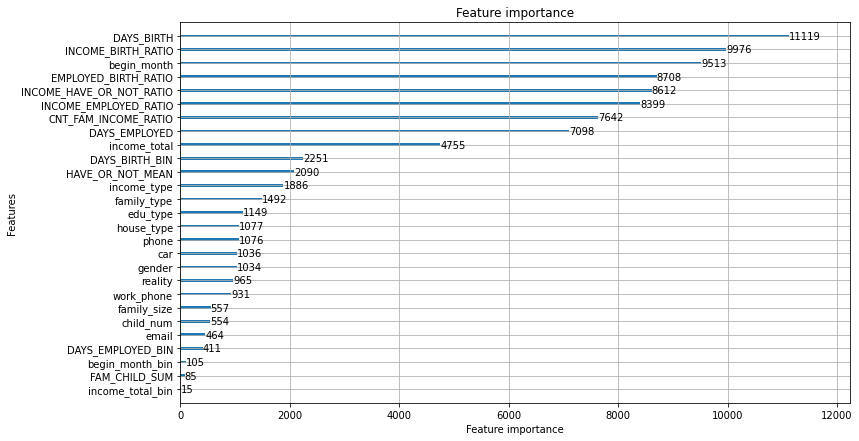

In [ ]:
from lightgbm import plot_importance
plot_importance(clf, figsize=(12,7))

In [ ]:
predictions = clf.predict_proba(test.drop('index', axis=1))
submission.iloc[:, 1:] = predictions 
submission.to_csv('submission_try02_3.csv', index=False)

### 5. 하이퍼파라미터 튜닝 후 학습/검증/예측 

#### 5-1 Bayesian Optimization 사용

In [ ]:
# 베이지안 옵티마이저 사용하여 하이퍼파라미터 튜닝 
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (8, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500),
    'reg_lambda':(0.001, 10),
    'reg_alpha': (0.01, 50) 
}

In [ ]:
def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin, reg_lambda, reg_alpha):
    params = {
        "n_estimators":500, "learning_rate":0.02,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10),
        'reg_lambda': max(reg_lambda,0),
        'reg_alpha': max(reg_alpha, 0)
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 100, 
                early_stopping_rounds= 100)
    valid_proba = lgb_model.predict(valid_x)
    f1score = f1_score(valid_y, valid_proba, average='macro')
    #accuracy = accuracy_score(valid_y, valid_proba)
    #return accuracy

    return f1score 

In [ ]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_roc_eval,bayesian_params , random_state=0)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.811728	training's multi_logloss: 0.811728	valid_1's multi_logloss: 0.81357	valid_1's multi_logloss: 0.81357
[200]	training's multi_logloss: 0.789614	training's multi_logloss: 0.789614	valid_1's multi_logloss: 0.798842	valid_1's multi_logloss: 0.798842
[300]	training's multi_logloss: 0.775987	training's multi_logloss: 0.775987	valid_1's multi_logloss: 0.792327	valid_1's multi_logloss: 0.792327
[400]	training's multi_logloss: 0.765342	training's multi_logloss: 0.765342	valid_1's multi_logloss: 0.788105	valid_1's multi_logloss: 0.788105
[500]	training's multi_logloss: 0.756828	training's multi_logloss: 0.756828	valid_1's multi_log

In [ ]:
# # BayesianOptimization객체의 res는 iteration 수행 시마다 모든 함수 반환결과와 그때의 파라미터 결과값을 가지고 있음. 
# lgbBO.res

In [ ]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

[0.39310358423113767, 0.39441700260112666, 0.4254950004385709, 0.39398746212125385, 0.39218605591475236, 0.4278552654364703, 0.39986437152144205, 0.39123488405038903, 0.39166532916031355, 0.39858666492111744, 0.3940661137894117, 0.4074813165507636, 0.39447691184675, 0.38915740945661303, 0.40743508524875766, 0.392053098098796, 0.44955335795197554, 0.42868147447494015, 0.40435639122005035, 0.424382549450906, 0.39986437152144205, 0.3932907064266746, 0.41667842790265697, 0.39193983365856305, 0.41171917313673373, 0.3949625879008734, 0.38898929574544877, 0.43412238698385447, 0.4592501526858131, 0.4451859331322828]
maximum target index: 28


In [ ]:
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

{'target': 0.4592501526858131, 'params': {'colsample_bytree': 0.7674567512954314, 'max_bin': 269.6109200398602, 'max_depth': 13.896975914831401, 'min_child_samples': 68.26720342186422, 'min_child_weight': 9.013217831887559, 'num_leaves': 63.152516494223335, 'reg_alpha': 1.7639768328775685, 'reg_lambda': 0.688724140896305, 'subsample': 0.5009743194948411}}


#### 5-2 최적의 파라미터로 학습/예측 한번만 시행 

In [ ]:
# 최적화된 하이퍼 파라미터를 기반으로 재 테스트
# tunning_5 버전 
def train_all(train):
    ftr_train = train.drop(['index', 'credit'], axis=1)
    target_train = train['credit']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_train, target_train, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=1000,
                learning_rate=0.02,
                max_depth = 15,
                num_leaves=58,
                colsample_bytree=0.870,
                subsample=0.674,
                max_bin=91,
                reg_alpha=1.841,
                reg_lambda=0.039,
                min_child_weight=2,
                min_child_samples=13,
                silent=-1,
                verbose=-1,
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 100, 
                early_stopping_rounds= 100)
    
    return clf

In [ ]:
# 최적화된 하이퍼 파라미터를 기반으로 재 테스트
# tunning_3_2 버전 
def train_all(train):
    ftr_train = train.drop(['index', 'credit'], axis=1)
    target_train = train['credit']

    train_x, valid_x, train_y, valid_y = train_test_split(ftr_train, target_train, test_size=0.3, random_state=2020)
    print('train shape:', train_x.shape, 'valid shape:', valid_x.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=1000,
                learning_rate=0.02,
                max_depth = 14,
                num_leaves=63,
                colsample_bytree=0.767,
                subsample=0.501,
                max_bin=270,
                reg_alpha=1.764,
                reg_lambda=0.689,
                min_child_weight=9,
                min_child_samples=68,
                silent=-1,
                verbose=-1,
                )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 100, 
                early_stopping_rounds= 100)
    
    return clf

In [ ]:
train = data[~data['credit'].isnull()]
test = data[data['credit'].isnull()]
test = test.drop('credit', axis=1)
train.shape , test.shape 

((26457, 30), (10000, 29))

In [ ]:
clf = train_all(train)

train shape: (18519, 28) valid shape: (7938, 28)
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.747335	training's multi_logloss: 0.747335	valid_1's multi_logloss: 0.796219	valid_1's multi_logloss: 0.796219
[200]	training's multi_logloss: 0.69278	training's multi_logloss: 0.69278	valid_1's multi_logloss: 0.774333	valid_1's multi_logloss: 0.774333
[300]	training's multi_logloss: 0.653517	training's multi_logloss: 0.653517	valid_1's multi_logloss: 0.763178	valid_1's multi_logloss: 0.763178
[400]	training's multi_logloss: 0.62304	training's multi_logloss: 0.62304	valid_1's multi_logloss: 0.756523	valid_1's multi_logloss: 0.756523
[500]	training's multi_logloss: 0.597562	training's multi_logloss: 0.597562	valid_1's multi_logloss: 0.75112	valid_1's multi_logloss: 0.75112
[600]	training's multi_logloss: 0.574393	training's multi_logloss: 0.574393	valid_1's multi_logloss: 0.746415	valid_1's multi_logloss: 0.746415
[700]	training's multi_logloss

In [ ]:
submission = pd.read_csv('/content/data/sample_submission.csv')

In [ ]:
predictions = clf.predict_proba(test.drop('index', axis=1))
submission.iloc[:, 1:] = predictions
submission.to_csv('submission_try02_tunning_5.csv', index=False)

#### 5-3. 최적의 파라미터로 OOF 검증하여 학습/예측 시행 

In [ ]:
from sklearn.model_selection import StratifiedKFold

def train_apps_all_with_oof(train, test, nfolds=5):
    ftr_train = train.drop(['index', 'credit'], axis=1)
    target_train = train['credit']

    # nfolds 개의 cross validatin fold set을 가지는 KFold 생성 
    folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=2020)
    
    #  Out of Folds로 학습된 모델의 validation set을 예측하여 결과 확률을 담을 array 생성.
    # validation set가 n_split갯수만큼 있으므로 크기는 ftr_app의 크기가 되어야 함. 
    # oof_preds = np.zeros(ftr_train.shape[0])  
    
    # Ouf of Folds로 학습된 모델의 test dataset을 예측하여 결과 확률을 담을 array 생성. 
    test_preds = np.zeros((test.shape[0], 3))
    
    # n_estimators를 4000까지 확대. 
    clf = LGBMClassifier(
                  nthread=4,
                  n_estimators=4000,
                  learning_rate=0.01,
                  max_depth = 15,
                  num_leaves=58,
                  colsample_bytree=0.870,
                  subsample=0.674,
                  max_bin=91,
                  reg_alpha=1.841,
                  reg_lambda=0.039,
                  min_child_weight=2,
                  min_child_samples=13,
                  silent=-1,
                  verbose=-1,
                  )
                  
    # nfolds 번 cross validation Iteration 반복하면서 OOF 방식으로 학습 및 테스트 데이터 예측
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(ftr_train, target_train)):
        print('##### iteration ', fold_idx, ' 시작')
        # 학습용 데이터 세트의 인덱스와 검증용 데이터 세트의 인덱스 추출하여 이를 기반으로 학습/검증 데이터 추출
        train_x  = ftr_train.iloc[train_idx, :]
        train_y = target_train.iloc[train_idx]
        valid_x = ftr_train.iloc[valid_idx, :]
        valid_y = target_train.iloc[valid_idx]
        
        # 추출된 학습/검증 데이터 세트로 모델 학습. early_stopping은 200으로 증가. 
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric= 'logloss', verbose= 200, 
                early_stopping_rounds= 200)
        # 검증 데이터 세트로 예측된 확률 저장. 사용되지는 않음. 
        # oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]       
        # 학습된 모델로 테스트 데이터 세트에 예측 확률 계산. 
        # nfolds 번 반복 실행하므로 평균 확률을 구하기 위해 개별 수행시 마다 수행 횟수로 나눈 확률을 추후에 더해서 최종 평균 확률 계산. 
        test_preds += clf.predict_proba(test.drop('index', axis=1), num_iteration=clf.best_iteration_)/folds.n_splits
        
        
    return clf, test_preds

In [ ]:
clf, test_preds = train_apps_all_with_oof(train, test, nfolds=5)

##### iteration  0  시작
Training until validation scores don't improve for 200 rounds.
[200]	training's multi_logloss: 0.74641	training's multi_logloss: 0.74641	valid_1's multi_logloss: 0.794658	valid_1's multi_logloss: 0.794658
[400]	training's multi_logloss: 0.695127	training's multi_logloss: 0.695127	valid_1's multi_logloss: 0.774351	valid_1's multi_logloss: 0.774351
[600]	training's multi_logloss: 0.660807	training's multi_logloss: 0.660807	valid_1's multi_logloss: 0.764565	valid_1's multi_logloss: 0.764565
[800]	training's multi_logloss: 0.630844	training's multi_logloss: 0.630844	valid_1's multi_logloss: 0.757602	valid_1's multi_logloss: 0.757602
[1000]	training's multi_logloss: 0.605362	training's multi_logloss: 0.605362	valid_1's multi_logloss: 0.751738	valid_1's multi_logloss: 0.751738
[1200]	training's multi_logloss: 0.583417	training's multi_logloss: 0.583417	valid_1's multi_logloss: 0.748062	valid_1's multi_logloss: 0.748062
[1400]	training's multi_logloss: 0.563644	training

In [ ]:
submission = pd.read_csv('/content/data/sample_submission.csv')

In [ ]:
submission.iloc[:, 1:] = test_preds
submission.to_csv('submission_try02_tunning_3_2_oof.csv', index=False)